# Data exploration and preprocessing

This file aims to explore the image data. This project will use two kinds of data, satellite image tiles and a file describe them. The data is download from the **the tiles** and **my dropbox** links in http://ataspinar.com/2017/12/04/using-convolutional-neural-networks-to-detect-features-in-sattelite-images/ respectively.

The images are stored in FOLDER_IMG. The images are contiguous tiles of satellite imagery of the Netherlands. An image is named by its coordinates. For example, the four coordinates of the image "100400_429200_100600_429400.jpg" are $(100400, 429200)$, $(100600, 429200)$, $(100600, 429400)$, $(100400, 429400)$. The all images cover the block in $(95000, 42700)$, $(110000, 447000)$.

There are 4 types of roads, municipality, province, government, water management authorities. The images are labeled with 6 labels: no road, municipality, province, government, water management authorities, multiple types. The data provided is very imbalanced. To tackle this problem, the minority classes are augmented by rotation and changing color gitter.

## 1. Data

Use the .json file

In [1]:
import sys
sys.path.insert(0,'..')

import os
import json
import pickle
import requests
import shutil
import random
import numpy as np

from collections import defaultdict
from scipy import ndimage
from datetime import date
from datetime import datetime

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import matplotlib.pyplot as plt

Explore the description dataset

In [2]:
filename_wegvakken = "../data/nwb_wegvakken/2017_09_wegvakken.json"
dict_wegvakken = json.load(open(filename_wegvakken))['features']

In [13]:
dict_roadtype = {
    "G": 'Municipality',
    "R": 'Government',
    "P": 'Province',
    "W": 'Water management authorities',
    'T': 'Other type',
    "M": 'Multi types',
    "": 'No road',
    "0": 'No road'
}

PROPERTIES_KEY = 'properties'
ROAD_TYPE_KEY = 'WEGBEHSRT'
GEOMETRY_KEY = 'geometry'
COORDINATES_KEY = 'coordinates'

POINTS_PER_METER = 0.1
dx = 200
dy = 200

x_min = 95000
y_min = 427000
x_max = 110000
y_max = 447000
bounding_box = [x_min, y_min, x_max, y_max]

FOLDER_IMG = '../datasets/image_tiles_200/'

### Data Labeling

There are 4 types of roads, _municipality, province, government, water management authorities._

The dictionary file gives the road type information for some points. For any given coordinates, if they're in a tile, or any lines between some them cut through some tiles, then those tiles are label by the type of road.

Here we create two dictionaries, whose keys are the name of images and values are the roads in the image, one stores the true label of each image, one stores the merged label of each image (if a image contains more than one type of roads, its label is multi roads).

In [4]:
def add_to_dict(d1, d2, d3, coordinates, rtype):
    """
    d1: dict_tile_contents, tile: road segmentation
    d2: dict_rtype_tile, road type: tiles
    d3: dict_tile_rtype, tile: road type
    """
    coordinate_ll_x = int((coordinates[0] // dx)*dx)
    coordinate_ll_y = int((coordinates[1] // dy)*dy)
    coordinate_ur_x = int((coordinates[0] // dx)*dx + dx)
    coordinate_ur_y = int((coordinates[1] // dy)*dy + dy)
    tile = "{}_{}_{}_{}.jpg".format(coordinate_ll_x, coordinate_ll_y, coordinate_ur_x, coordinate_ur_y)
    
    rel_coord_x = (coordinates[0] - coordinate_ll_x) / dx
    rel_coord_y = (coordinates[1] - coordinate_ll_y) / dy
    value = (rtype, rel_coord_x, rel_coord_y)
    d1[tile].append(value)
    d2[rtype].add(tile)
    d3[tile].add(rtype)

def coord_is_in_bb(coord, bb):
    """Check whether the coordinate is in the bounding box"""
    x_min = bb[0]
    y_min = bb[1]
    x_max = bb[2]
    y_max = bb[3]
    return coord[0] > x_min and coord[0] < x_max and coord[1] > y_min and coord[1] < y_max

def retrieve_roadtype(elem):
    return elem[PROPERTIES_KEY][ROAD_TYPE_KEY]
   
def retrieve_coordinates(elem):
    return elem[GEOMETRY_KEY][COORDINATES_KEY]

def eucledian_distance(p1, p2):
    diff = np.array(p2)-np.array(p1)
    return np.linalg.norm(diff)

def calculate_intermediate_points(p1, p2, no_points):
    dx = (p2[0] - p1[0]) / (no_points + 1)
    dy = (p2[1] - p1[1]) / (no_points + 1)
    return [[p1[0] + i * dx, p1[1] +  i * dy] for i in range(1, no_points+1)]

In [5]:
d_tile_contents = defaultdict(list)
d_roadtype_tiles = defaultdict(set)
d_tile_rtype = defaultdict(set)

for elem in dict_wegvakken:
    coordinates = retrieve_coordinates(elem)
    rtype = retrieve_roadtype(elem)
    coordinates_in_bb = [coord for coord in coordinates if coord_is_in_bb(coord, bounding_box)]
    #coordinates_in_bb = [coord for coord in coordinates if coord_is_in_bb(coord, small_box)]
    if len(coordinates_in_bb)==1:
        coord = coordinates_in_bb[0]
        add_to_dict(d_tile_contents, d_roadtype_tiles, d_tile_rtype, coord, rtype)
    if len(coordinates_in_bb)>1:
        add_to_dict(d_tile_contents, d_roadtype_tiles, d_tile_rtype, coordinates_in_bb[0], rtype)
        for ii in range(1,len(coordinates_in_bb)):
            previous_coord = coordinates_in_bb[ii-1]
            coord = coordinates_in_bb[ii]
            add_to_dict(d_tile_contents, d_roadtype_tiles, d_tile_rtype,coord, rtype)
            
            dist = eucledian_distance(previous_coord, coord)
            no_intermediate_points = int(dist*POINTS_PER_METER)           
            intermediate_coordinates = calculate_intermediate_points(previous_coord, coord, no_intermediate_points)
            for intermediate_coord in intermediate_coordinates:
                add_to_dict(d_tile_contents, d_roadtype_tiles, d_tile_rtype, intermediate_coord, rtype)

In [6]:
print("{} tiles contain roads.".format(len(d_tile_contents)))

4947 tiles contain roads.


Here we start to label the all images.

In [7]:
data_img = os.listdir(FOLDER_IMG)

In [8]:
d_tile_label = defaultdict(str)
for img in data_img:
    tmp_road = ''
    for r in list(d_tile_rtype[img]):
        tmp_road += '-'+r
    d_tile_label[img] = tmp_road[1:]

In [9]:
"""Encoder the rtype"""
rtype2int = {'':0, 'G':1, 'P':2, 'R':3, 'W':4, 'M':5}
data_pair = defaultdict(int)
for tile in d_tile_label.keys():
    if len(d_tile_label[tile])>1:
        data_pair[tile] = rtype2int['M']
    else:
        data_pair[tile] = rtype2int[d_tile_label[tile]]

In [10]:
int2rtype = {0: '0', 1:'G', 2:'P', 3:'R', 4:'W',  5:'M'}

Stats of data

In [11]:
d_rtype_counts = defaultdict(int)
d_rtype_cnt_merge = defaultdict(int)
for img in d_tile_label.keys():
    d_rtype_counts[d_tile_label[img]] += 1
    if len(d_tile_label[img])>1:
        d_rtype_cnt_merge['M'] += 1
    else:
        d_rtype_cnt_merge[d_tile_label[img]] += 1
for i, rt in enumerate(sorted(d_rtype_counts.keys())):
    print(i, rt, d_rtype_counts[rt])

print()
cnt = 0
for rt in sorted(d_rtype_cnt_merge.keys()):
    print(rt, d_rtype_cnt_merge[rt])
    cnt += d_rtype_cnt_merge[rt]

print('\n{}'.format(cnt))

0  2553
1 G 3174
2 G-P 110
3 G-P-R 5
4 G-P-W 12
5 G-R 205
6 G-R-W 40
7 G-T 1
8 G-W 232
9 P 113
10 P-R 2
11 P-R-W 1
12 P-W 49
13 R 70
14 R-W 70
15 W 863

 2553
G 3174
M 727
P 113
R 70
W 863

7500


In [12]:
R_Folder = '../result/week2/'

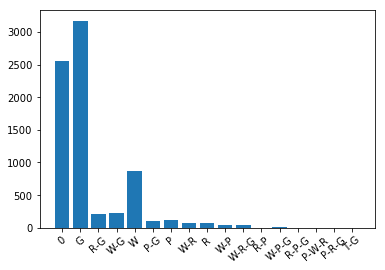

In [13]:
x = [k if len(k)>0 else '0' for k in d_rtype_counts.keys()]
y = [d_rtype_counts[k] if k!='0' else d_rtype_counts[''] for k in x]
x_n = [i for i in range(len(x))]
plt.bar(x_n, y)
#plt.xticks(x_n,x,rotation='vertical')
plt.xticks(x_n,x,rotation=40)
plt.show()

In [14]:
d_rtype_cnt_merge['R']

70

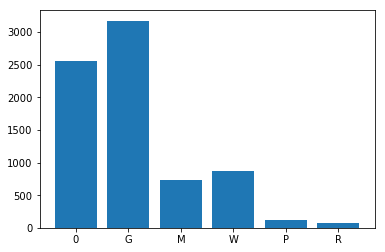

In [14]:
x = [k if len(k)>0 else '0' for k in d_rtype_cnt_merge.keys()]
#x_label = [dict_roadtype[k] for k in d_rtype_cnt_merge.keys()]
y = [d_rtype_cnt_merge[k] if k!='0' else d_rtype_cnt_merge[''] for k in x]
x_n = [i for i in range(len(x))]
plt.bar(x_n, y)
#plt.xticks(x_n,x,rotation='vertical')
plt.xticks(x_n,x,rotation=0)
plt.show()

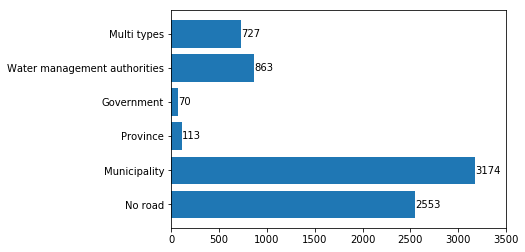

In [20]:
x = sorted(list(int2rtype.keys()))
y = [d_rtype_cnt_merge[int2rtype[k]] if k>0 else d_rtype_cnt_merge[''] for k in x]
x_label = [int2rtype[k] for k in x]
x_label1 = [dict_roadtype[k] for k in x_label]

fig, ax = plt.subplots(figsize=(6.0, 4.0))
bar = plt.barh(x, y)
plt.yticks(x,x_label1,rotation=0, ha="right")
x_in = [500*k for k in range(8)]
plt.xticks(x_in)

for i, v in enumerate(y):
    ax.text(v + 3, i, str(v), va='center')

plt.savefig('../results/road_type.jpg', dpi=750, bbox_inches = "tight")
plt.show()

### Split dataset into train dataset and validatiaon dataset

In [15]:
TRAIN_SIZE = 6000
VAL_SIZE = 1500

In [31]:
data = list(data_pair)
random.shuffle(data)
data_train = data[:TRAIN_SIZE]
data_val = data[TRAIN_SIZE:]

In [35]:
import pickle

with open('../data/data_train.pkl', 'wb') as f:
     pickle.dump(data_train, f)
        
with open('../data/data_val.pkl', 'wb') as f:
    pickle.dump(data_val, f)

with open('../data/data_pair.pkl', 'wb') as f:
    pickle.dump(data_pair, f)

## Try to augmentate data

1. Classify the multi-type tiles into different road type
    1. multi-class contains P to P
    2. multi-class contains R to R
    3. multi-class contains both P and R to R
2. Upsample Type P and Type R by rotation and changing color jitter
3. Build a data structure to link the tile name, tile label, augmente operation 'Copy', 'Rotate'... (Just randomly do it to all data)

In [64]:
import pickle

with open('../data/dict_tile_label_true.pkl','wb') as f:
    pickle.dump(d_tile_label, f)

In [32]:
d_label_tile_train = defaultdict(list)
for k in data_train:
    if d_tile_label[k]=='':
        d_label_tile_train['0'].append(k)
    else:
        d_label_tile_train[d_tile_label[k]].append(k)

In [33]:
d_label_tile_train.keys()

dict_keys(['0', 'G', 'P', 'W', 'W-G', 'R', 'R-G', 'W-R-G', 'P-G', 'W-P', 'W-R', 'R-P', 'W-P-G', 'R-P-G', 'T-G', 'P-R-G'])

In [34]:
int2rtype = {0: '0', 1:'G', 2:'P', 3:'R', 4:'W', 5:'M'}

In [35]:
d_label_tile_merge = defaultdict(list)
d_label_tile_merge['0'] = d_label_tile_train['0']
# d_label_tile_merge['G'] = d_label_tile['G']+d_label_tile['T-G']
# d_label_tile_merge['P'] = d_label_tile['P'] + d_label_tile['G-P'] + d_label_tile['W-P'] + d_label_tile['G-W-P'] + d_label_tile['R-W-P']
# d_label_tile_merge['R'] = d_label_tile['R'] + d_label_tile['G-R'] + d_label_tile['R-W'] + d_label_tile['G-R-W'] + d_label_tile['R-P'] + d_label_tile['G-R-P']
# d_label_tile_merge['W'] = d_label_tile['W'] + d_label_tile['G-W']
d_label_tile_merge['G'] = d_label_tile_train['G']
d_label_tile_merge['P'] = d_label_tile_train['P'] 
d_label_tile_merge['R'] = d_label_tile_train['R']
d_label_tile_merge['W'] = d_label_tile_train['W'] 
d_label_tile_merge['M'] = d_label_tile_train['T-G'] + d_label_tile_train['G-P'] + d_label_tile_train['W-P'] + d_label_tile_train['G-W-P'] + d_label_tile_train['R-W-P']  + \
    d_label_tile_train['G-R'] + d_label_tile_train['R-W'] + d_label_tile_train['G-R-W'] + d_label_tile_train['R-P'] + d_label_tile_train['G-R-P'] +d_label_tile_train['T-G'] + \
    d_label_tile_train['G-P'] + d_label_tile_train['W-P'] + d_label_tile_train['G-W-P'] + d_label_tile_train['R-W-P'] + d_label_tile_train['G-W']

In [37]:
for k in d_label_tile_merge.keys():
    print(k, len(d_label_tile_merge[k]))

0 2042
G 2551
P 86
R 50
W 693
M 80


In [38]:
data_train_up = []

data_train_up += d_label_tile_merge['0']
data_train_up += d_label_tile_merge['G']
data_train_up += 20*d_label_tile_merge['P']
data_train_up += 40*d_label_tile_merge['R']
data_train_up += 3*d_label_tile_merge['W']
data_train_up += d_label_tile_merge['M']

In [41]:
len(list(set(data_pair.values())))

6

In [21]:
int2rtype = {0: '0', 1:'G', 2:'P', 3:'R', 4:'W',  5:'M'}
dict_roadtype = {
    "G": 'Municipality',
    "R": 'Goverment',
    "P": 'Province',
    "W": 'Water managerment authorities',
    'T': 'Other type',
    "M": 'Multi types',
    "": 'No road',
    "0": 'No road'
}

import pickle

with open('../data/data_train.pkl', 'rb') as f:
     data_train = pickle.load(f)
        
with open('../data/data_val.pkl', 'rb') as f:
    data_val = pickle.load(f)

with open('../data/data_pair.pkl', 'rb') as f:
    data_pair = pickle.load(f)

# with open('../data/dict_tile_label_true.pkl', 'rb') as f:
#     data_tile_label = pickle.load(f)
    
FOLDER_IMG = '../datasets/image_tiles_200/'

def classify_roads(data, data_pair):
    d_tile_imgs = defaultdict(list)
    for img in data:
        d_tile_imgs[data_pair[img]].append(img)
    return d_tile_imgs

d_tile_imgs_train = classify_roads(data_train, data_pair)
for k in sorted(d_tile_imgs_train.keys()):
    print('{}, {}, {}'.format(int2rtype[k], dict_roadtype[int2rtype[k]], len(d_tile_imgs_train[k])))

0, No road, 2044
G, Municipality, 2544
P, Province, 92
R, Goverment, 53
W, Water managerment authorities, 694
M, Multi types, 573


In [22]:
def upsample(d_tile_imgs, upsample_scale):
    data = []
    for k in d_tile_imgs.keys():
        data += d_tile_imgs[k]*upsample_scale[k]
    return data

upsample_scale = {0: 1, 1:1, 2:20, 3:30, 4:3, 5:3}
data_train = upsample(d_tile_imgs_train, upsample_scale)
a = classify_roads(data_train, data_pair)
for k in sorted(a.keys()):
    print('{}, {}, {}'.format(int2rtype[k], dict_roadtype[int2rtype[k]], len(a[k])))

0, No road, 2044
G, Municipality, 2544
P, Province, 1840
R, Goverment, 1590
W, Water managerment authorities, 2082
M, Multi types, 1719


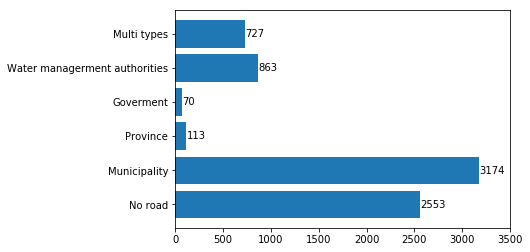

In [23]:
x = sorted(list(int2rtype.keys()))
y = [d_rtype_cnt_merge[int2rtype[k]] if k>0 else d_rtype_cnt_merge[''] for k in x]
x_label = [int2rtype[k] for k in x]
x_label1 = [dict_roadtype[k] for k in x_label]

fig, ax = plt.subplots(figsize=(6.0, 4.0))
bar = plt.barh(x, y)
plt.yticks(x,x_label1,rotation=0, ha="right")
x_in = [500*k for k in range(8)]
plt.xticks(x_in)

for i, v in enumerate(y):
    ax.text(v + 3, i, str(v), va='center')
plt.show()

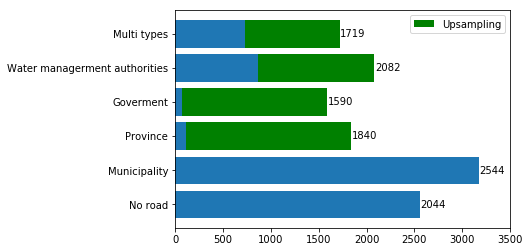

In [30]:
x = sorted(list(int2rtype.keys()))

y = [d_rtype_cnt_merge[int2rtype[k]] if k>0 else d_rtype_cnt_merge[''] for k in x]
y_up = [len(a[k]) for k in x]
x_label = [int2rtype[k] for k in x]
x_label1 = [dict_roadtype[k] for k in x_label]

ax = plt.subplot(111)
ax.barh(x, y_up, color='g', align='center', label = 'Upsampling')
ax.barh(x, y, align='center')

plt.yticks(x,x_label1,rotation=0, ha="right")
x_in = [500*k for k in range(8)]
plt.xticks(x_in)


for i, v in enumerate(y_up):
    ax.text(max(v, y[i]) + 3, i,  str(v), va='center')
    
plt.legend()
plt.savefig('../results/week2/road_type_upsampling.jpg', dpi=500, bbox_inches = "tight")
plt.show()

### Create Dataset and DataLoader

In [44]:
import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms as transforms

import random

In [45]:

class Insight_Dataset(Dataset):
    """
    The size of image is (3, 256, 256)
    """
    def __init__(self, img_folder, data, pair):
        self.folder = img_folder
        self.data = data
        #self.keys = list(d_tile_label.keys()).sort(key=lambda x: [int(x.split('_')[0]), int(x.split('_')[1])])
        self.pair = pair
        self.colorjitter = transforms.ColorJitter()
        
    
    def __len__(self):
        return len(self.data)
    

    def __getitem__(self, idx):
        '''
        return （image, label）
        '''
        tile_name = self.folder + self.data[idx]
        img = plt.imread(tile_name)
        label = self.pair[self.data[idx]]
        k = random.randint(0,9)
        if k==0:
            img = img.transpose(1,0,2)
        elif k==1:
            img = img.transpose(1,0,2)
            img = img.transpose(1,0,2)
        elif k==2:
            img = img.transpose(1,0,2)
            img = img.transpose(1,0,2)
            img = img.transpose(1,0,2)
        else:
            img = self.colorjitter(img)
        return (torch.FloatTensor(img.T), label)


In [46]:
BATCH_SIZE = 32
train_data = Insight_Dataset(FOLDER_IMG, data_train, data_pair)
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)
val_data = Insight_Dataset(FOLDER_IMG, data_val, data_pair)
val_loader = torch.utils.data.DataLoader(dataset=val_data,
                                        batch_size = BATCH_SIZE,
                                        shuffle = True)